In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants as C
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, cartesian_to_spherical 
from astropy.time import Time
from astropy import units as u
import tqdm 
import matplotlib.animation as anim
from astropy.visualization import astropy_mpl_style, quantity_support
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

### 17th Feb:

**Conditional about observations:**

The user gives the latitude and the functions returns if the phenomenon can be see it or not. This using the conditional "altitude > 0 degrees" but with the difference of taking into account the time of observation on the altitude-Azimuth coordinate system; this is the equivalent ofr the conditional of "dec > 90-latitude".   

Alert system's input format: RA, Dec (hmsdms); Latitude, longitude (DMS); militar hour (hms) using J200 
(Reference: https://ztf.uw.edu/alerts/public/)

**About the sing on the coordinates**
 A positive value for North and East, a negative value for South and West. (Reference: https://tnp.uservoice.com/knowledgebase/articles/172110-latitude-longitude-formats-and-conversion)

In [2]:
#Playtime data
lat_obs = '4-35-56-N' 
lon_obs = '74-04-51-W'   
name = ['Aldebaran','Polar Star', 'Antares']
ra_list = ['04h35m55.64s','02h31m19.79s','16h29m24.17s'] 
dec_list = ['+16d30m27.2s','+89d16m10.10s','-26d25m53.56s']
date = '2025-02-17 21:30:00'

#moving time
date_i = '2025-02-17 19:00:00'
date_f = '2025-02-18 05:00:00'
timescale = ['h', 1]

In [3]:
#Convert the DMS format to degrees
def ConvertLaLo(l):
    l_ = l.split('-')
    D = float(l_[0])
    M = float(l_[1])
    S = float(l_[2])
    dir = l_[3]
    r = D + (M/60) + (S/3600)
    if dir=='W' or dir=='S':
        return r*(-1)
    else:
        return r

ConvertLaLo(lon_obs)

-74.08083333333333

In [4]:
def Observations(longitude, latitude, RA, DEC, Date):
    time_obs = Time(Date)
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)
    Conditionals = []

    for i in range(0,len(RA)):

        celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #mantain the degrees units

        # Calculate the coordenates AltAz for the time and observer
        frame_altaz = AltAz(obstime=time_obs, location=observer)
        altaz_coord = celestial_coord.transform_to(frame_altaz) #Transform for the J200 coordinate system for altaz
    
        # Determinate if its observable (altitude > 0 degrees), return a boolean
        Conditionals.append(altaz_coord.alt > 0*u.deg)

    #Put everything on a dataframe in the format for better reading
    Data = pd.DataFrame([])
    Data.style.set_caption(Date)
    Data['Observable'] = Conditionals
    Data['RA'] = RA
    Data['Dec'] = DEC

    return Data

Observations(lon_obs, lat_obs, ra_list, dec_list, date)

,Observable,RA,Dec
0,True,04h35m55.64s,+16d30m27.2s
1,True,02h31m19.79s,+89d16m10.10s
2,False,16h29m24.17s,-26d25m53.56s


### 21th Feb

Now we need to expand the function for a time slot, establish by the user. With this condition, is necesary to report if its observable. An idea is refreshing the dataframe with a nonsmall step, such we can determine if the function is returning what we want. 

Change the scale of time to UTC and keep the format iso for maintain the international format.

Actually, the function Time of astropy simplifies the code because allows sum seconds, hour and minutes in a line.
(Reference: https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.FORMATS)

In [5]:
def MoveTime(time_actual,scale,sc):
    if scale == 's':
        t = time_actual + sc*u.second 
    if scale == 'm':
        t = time_actual + sc*u.minute
    if scale == 'h':
        t = time_actual + sc*u.hour

    return t

MoveTime(Time(date,scale='utc',format='iso'),'h',1)

<Time object: scale='utc' format='iso' value=2025-02-17 22:30:00.000>

In [6]:
#With time slot and optimized

def Observations(longitude, latitude, RA, DEC, Date_i, Date_f,time_scale):
    actual_time = Time(Date_i,format = 'iso', scale='utc')
    final_time = Time(Date_f,format = 'iso', scale='utc')
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)
    Big_Data = []
    Time_values = []

    while actual_time <= final_time:
        Conditionals = []

        for i in range(0,len(RA)):

            celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #mantain the degrees units

            # Calculate the coordenates AltAz for the time and observer
            frame_altaz = AltAz(obstime=actual_time, location=observer)
            altaz_coord = celestial_coord.transform_to(frame_altaz) #Transform for the J200 coordinate system for altaz
    
            # Determinate if its observable (altitude > 0 degrees), return a boolean
            Conditionals.append(altaz_coord.alt > 0*u.deg)

        #Put everything on a dataframe in the format for better reading
        Data = pd.DataFrame([])
        Data['Observable'] = Conditionals
        Data['RA'] = RA
        Data['Dec'] = DEC
        Big_Data.append(Data) 
        Time_values.append(actual_time)

        actual_time = MoveTime(actual_time,time_scale[0],time_scale[1])

    return Big_Data,Time_values

Data, times = Observations(lon_obs, lat_obs, ra_list, dec_list, date_i, date_f,timescale)

### 24 Feb - 3 Mar
This week have two objectives: 

1) Implemnt a preference condition, just show the observables and organized with preference of higher altitude.

2) Try to simulate for see in the time slot only the observables with the observer as the center. First we need to get the coordinates of the observables in the altaz format.

In [ ]:
#Playtime data
lat_obs = '4-35-56-N' 
lon_obs = '74-04-51-W'   
name = ['Aldebaran','Polar Star', 'Antares']
ra_list = ['04h35m55.64s','02h31m19.79s','16h29m24.17s'] 
dec_list = ['+16d30m27.2s','+89d16m10.10s','-26d25m53.56s']
date = '2025-02-17 21:30:00'

#moving time
date_i = '2025-02-17 19:00:00'
date_f = '2025-02-18 05:00:00'
timescale = ['s',1]

: 

In [ ]:
#With time slot and optimized

def Observations(longitude, latitude, RA, DEC, Date_i, Date_f,time_scale,names):

    #Definition of different variables:
    actual_time = Time(Date_i,format = 'iso', scale='utc')
    final_time = Time(Date_f,format = 'iso', scale='utc')
    lat_conv = ConvertLaLo(latitude)
    lon_conv = ConvertLaLo(longitude)
    observer = EarthLocation(lat=lat_conv*u.deg, lon=lon_conv*u.deg)

    #Lists of data for post-analysis
    Big_Data = []

    #Establish the time slot
    while actual_time <= final_time:

        #For each time slot we need the data of the conditional about observations
        Conditionals = []
        az = []
        alt = []
        ra = []
        dec = []
        Cor = []
        code = []

        for i in range(0,len(RA)):

            #Establish the coordinates with the correction from geocentric calculations of astropy
            celestial_coord = SkyCoord(ra=RA[i], dec=DEC[i]) #Mantain the degrees units

            # Calculate the coordenates AltAz for the time and observer
            frame_altaz = AltAz(obstime=actual_time, location=observer)

            #Transform the J2000 coordinate system for altaz
            altaz_coord = celestial_coord.transform_to(frame_altaz) 

            #Transform to equatorial coordinates for report the ra and dec relative to observer
            equatorial_coord = altaz_coord.transform_to('icrs')
    
            # Determinate if its observable (altitude > 0 degrees) in the altaz coordinate system, return a boolean.
            # Only choose the observables
            state = altaz_coord.alt > 0*u.deg

            if state == True:
                Conditionals.append(state)
                az.append(altaz_coord.az.value)
                alt.append(altaz_coord.alt.degree)
                ra.append(equatorial_coord.ra.deg)
                dec.append(equatorial_coord.dec.deg)
                Cor.append([altaz_coord.cartesian.x, altaz_coord.cartesian.y, altaz_coord.cartesian.z])
                code.append(names[i])
        
        #Put the conditionals of a time slot on a dataframe in the format for better reading
        Data = pd.DataFrame([])
        Data['Name'] = code
        Data['Observable'] = Conditionals
        Data['Az'] = az
        Data['Alt'] = alt
        Data['RA'] = ra
        Data['DEC'] = dec
        Data['Coordinates'] = Cor

        #With the DataFrame we can organice by the higher altitude
        dat = (Data.sort_values(by='Alt', ascending=False, na_position='first')).reset_index(drop=True)

        #Put the dataframe in a list and the values of time
        Big_Data.append(dat) 

        #Actualize the time depending of the time scale
        actual_time = MoveTime(actual_time,time_scale[0],time_scale[1])

    return Big_Data

Data = Observations(lon_obs, lat_obs, ra_list, dec_list, date_i, date_f,timescale,name)

### Simulation and graphic sketch

In [ ]:
#Take the data from the analysis
def EstablishCoord(Data,i):
    ALT =[]
    AZ = []
    X= []
    Y= []
    Z= []
    names = []

    for each in Data:
        ALT.append(each['Alt'][i])
        AZ.append(each['Az'][i])
        X.append(each['Coordinates'][i][0])
        Y.append(each['Coordinates'][i][1])
        Z.append(each['Coordinates'][i][2])
        names.append(each['Name'][i])

    return ALT,AZ,X,Y,Z,names

def TransformSphere(theta, phi, center,radius):
    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)
    return x, y, z

#Create an array for plotting the time
time = np.linspace(Time(date_i,format = 'iso', scale='utc').datetime.hour-24,Time(date_f,format = 'iso', scale='utc').datetime.hour,len(Data))

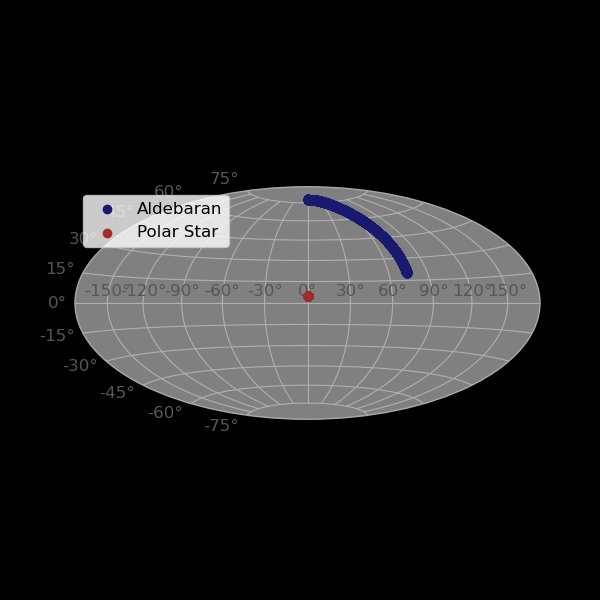

In [ ]:
#Create a figure 
fig1 = plt.figure(figsize=(6,6))  
ax1 = fig1.add_subplot(projection='hammer') 
#make the plot black
fig1.patch.set_facecolor('k') 
ax1.set_facecolor('gray')

#Stablish the interface
plt.style.use(astropy_mpl_style)
quantity_support()
list_colors=['midnightblue','brown']

# Plot the data of observables
for i in range(0,2):
    alt,az,x,y,z,names = EstablishCoord(Data,i)

    ax1.scatter(np.radians(az),np.radians(alt),color=list_colors[i],label='{}'.format(names[i]))
    ax1.legend()

#### 3D plot

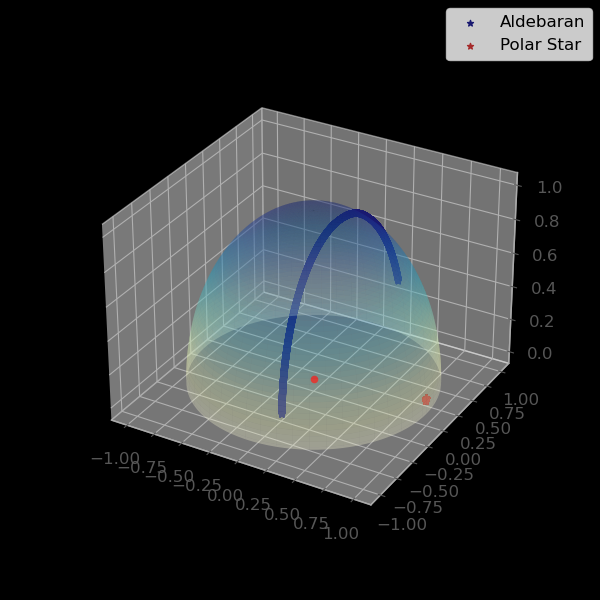

In [ ]:
#Create a figure 
fig3d = plt.figure(figsize=(6,6))  
ax3d = fig3d.add_subplot(projection='3d') 
#make the plot black
fig3d.patch.set_facecolor('k') 
ax3d.set_facecolor('k')

#Sphere parameters, for a projection we take the radius like one and the observer is on the center
center = (0, 0, 0)
radius = 1
phi = np.linspace(0, np.pi/2, 100)
theta = np.linspace(0, 2*np.pi, 100)

#Create a mesh grid for the sphere and plotting the "sky"
Phi, Theta = np.meshgrid(phi, theta)
X , Y, Z = TransformSphere(Theta, Phi, center,radius)
ax3d.plot_surface(X , Y, Z, cmap='YlGnBu', alpha=0.3) #Alpha is for oppacity

#The center
ax3d.scatter(center[0],center[1],center[2],color='r')

# Plot the data of observables
#First plot is for the astropy plot and second the projection in the hammer plot
list_colors=['midnightblue','brown']
for i in range(0,2):
    alt,az,x,y,z,names = EstablishCoord(Data,i)
    ax3d.scatter(x,y,z,marker='*',color=list_colors[i],label='{}'.format(names[i]))

fig3d.legend()

#### 3d simulation

In [ ]:
# # Crear la figura 3D
# fig3d = plt.figure(figsize=(6, 6))
# ax3d = fig3d.add_subplot(projection='3d')

# # Configurar el fondo negro
# fig3d.patch.set_facecolor('k')
# ax3d.set_facecolor('k')

# # Parámetros de la esfera
# center = (0, 0, 0)
# radius = 1
# phi = np.linspace(0, np.pi/2, 100)
# theta = np.linspace(0, 2*np.pi, 100)

# # Crear una malla para la esfera
# Phi, Theta = np.meshgrid(phi, theta)
# X, Y, Z = TransformSphere(Theta, Phi, center, radius)

# # Graficar la esfera
# ax3d.plot_surface(X, Y, Z, cmap='YlGnBu', alpha=0.3)

# # Graficar el centro
# ax3d.scatter(center[0], center[1], center[2], color='r')


# # Función para actualizar la animación
# def update(frame):
#     ax3d.clear()  # Limpiar el gráfico anterior
#     ax3d.set_facecolor('k')  # Restaurar el fondo negro

#     # Graficar la esfera nuevamente
#     ax3d.plot_surface(X, Y, Z, cmap='YlGnBu', alpha=0.3)

#     # Graficar el centro
#     ax3d.scatter(center[0], center[1], center[2], color='r')

#     # Actualizar los puntos observables
#     alt, az, x, y, z = EstablishCoord(Data, frame)

#     # Graficar los puntos observables
#     ax3d.scatter(x, y, z, marker='*', color='midnightblue')

#     # Convertir el valor de tiempo a un objeto Time de Astropy
#     current_time = Time(time[frame], format='jd', scale='utc')
#     time_str = current_time.iso  # Formatear como cadena ISO

#     # Añadir leyenda con el tiempo actual
#     ax3d.set_title(f'Tiempo: {time_str}')

#     # Configurar límites del gráfico
#     ax3d.set_xlim([-1, 1])
#     ax3d.set_ylim([-1, 1])
#     ax3d.set_zlim([-1, 1])

#     # Añadir leyenda
#     ax3d.legend(loc='upper right')

# # Crear la animación
# ani = FuncAnimation(fig3d, update, frames=len(Data), interval=200)
# plt.show()
# # Mostrar la animación